## Problem 4: Jump Diffusion Implied Volatility

### Import Libraries

In [ ]:
import numpy as np
from scipy.stats import norm, poisson
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from time import time

### Define Functions

#### Function 1: Implement a single simulation for prices using jump diffusion

In [ ]:
def jump_diffusion(S0, r, dt, sigma, steps, n_MC, lmbda, a, b):
    # Generate paths for the log-price and jump process
    Nt = np.random.poisson(lmbda * dt, size=(n_MC, steps))
    Y = np.exp(a + b * np.random.randn(n_MC, steps)) ## logY=randn (1 ,Nt)
    Z = np.random.randn(n_MC, steps)
    X = np.zeros((n_MC, steps))
    X[:, 0] = np.log(S0)
    for t in range(1, steps):
        drift = r - (lmbda * (np.exp(a + 0.5 * b**2) - 1)) - (0.5 * sigma ** 2)
        diffusion = sigma * np.sqrt(dt) * Z[:, t-1]
        M = np.log(Y[:, t-1]) * Nt[:, t-1]
        X[:, t] = X[:, t-1] + drift * dt + diffusion + M

    # Compute option prices and implied volatilities
    S = np.exp(X)
    return S[:,-1]

#### Function 2: Calculate Call Option Price

In [ ]:
def call_option_price(ST, Ks, r, T):
    P = np.zeros((len(ST), len(Ks)))  # Initialize array to hold option payoffs
    C = np.zeros(len(Ks))             # Initialize array to hold option prices
    for k, K in enumerate(Ks):
        # Compute option payoffs for each stock price and strike price
        P[:, k] = np.maximum(ST[:] - K, 0)
        # Compute the option price as the mean of the option payoffs, discounted to present value
        C[k] = np.mean(P[:, k]) * np.exp(-r * T)
    return C

#### Function 3: Calculate Implied Volatility using Newton Raphson's Method

In [ ]:
def implied_volatility(S0, C, Ks, r, T, tol = 1e-6, max_iter = 1000):
    IV = np.zeros(len(Ks))     # Initialize array to hold implied volatilities
    for k, K in enumerate(Ks):
        # Guess the implied volatility using the Black-Scholes formula
        IV_guess = np.sqrt(2 * abs((np.log(S0/K) + r * T + C[k]/S0) / T))
        # Iterate to refine the guess using Newton-Raphson method
        for n in range(max_iter):
            # Compute the option price and its sensitivity to volatility using Black-Scholes formula
            d1 = (np.log(S0/K) + (r + IV_guess**2/2) * T) / (IV_guess * np.sqrt(T))
            d2 = d1 - IV_guess * np.sqrt(T)
            C_guess = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            vega = S0 * norm.pdf(d1) * np.sqrt(T)
            # Update the implied volatility using Newton-Raphson formula
            IV_new = IV_guess - (C_guess - C[k]) / (vega + 1e-4)
            # Check if the convergence criterion is satisfied
            if abs(IV_new - IV_guess) < tol:
                IV[k] = IV_new
                break
            else:
                IV_guess = IV_new
    return IV

#### Function 4: Plot each graph in a m*n subplot

In [ ]:
def plot_IV_vs_log_moneyness(i, j, lmbda, a, Ks, S0, IV, smooth=False):
    """
    Plots implied volatility against log-moneyness.

    Args:
    i (int): row index of the subplot
    j (int): column index of the subplot
    lmbda (float): parameter of the jump diffusion process
    a (float): parameter of the jump diffusion process
    Ks (ndarray): array of strike prices
    S0 (float): initial stock price
    IV (ndarray): array of implied volatility values
    smooth (bool): whether to apply Savitzky-Golay filter to smooth the line

    Returns:
    None
    """
    if smooth:
        # Apply Savitzky-Golay filter to smoothen the line
        IV_smooth = savgol_filter(IV, window_length=11, polyorder=2)
        axs[i,j].plot(np.log(Ks/S0), IV_smooth, 'o-', label='Implied volatility')
    else:
        axs[i,j].plot(np.log(Ks/S0), IV, 'o-')
    axs[i,j].set_xlabel('Log-moneyness')
    axs[i,j].set_ylabel('Implied volatility')
    axs[i,j].set_title(f"Lambda = {lmbda}, A = {a}")

### Set Model Parameters

In [ ]:
S0 = 100
r = 0.05
sigma = 0.3
T = 1/12
dt = 1/(4*365)
b = 0.1
lmbda = [2, 5]
a = [-0.1, 0.1]

### Set option parameters

In [ ]:
Ks = np.arange(90, 121)
n_Ks = len(Ks)
n_MC = 20000
steps = int(T/dt) + 1

### Initialize arrays to store results

In [ ]:
ST = np.zeros(n_MC)

### Create a m*n subplot

Total Computation time is: 1.172874927520752


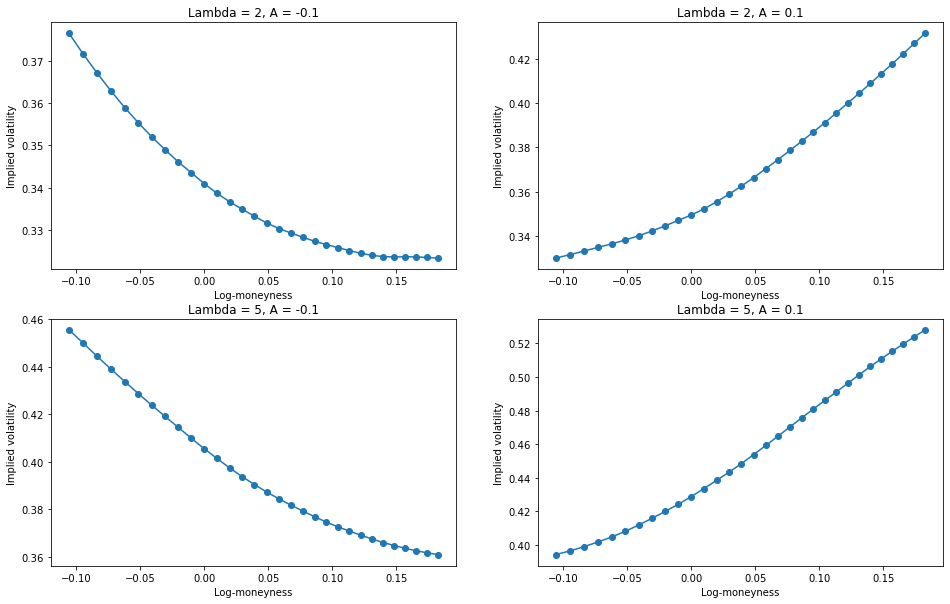

In [ ]:
# create a figure with subplots
fig, axs = plt.subplots(nrows=len(lmbda), ncols=len(a), figsize=(16, 10))

start = time()

# loop over each value of lambda and a to generate plots for each combination
for i, l in enumerate(lmbda):
    for j, a0 in enumerate(a):
        # generate 20000 jump diffusion paths using given parameters and get prices at time T
        ST = jump_diffusion(S0, r, dt, sigma, steps, n_MC, l, a0, b)

        # calculate call option prices for each strike price using the generated jump diffusion paths
        C = call_option_price(ST, Ks, r, T)

        # calculate implied volatilities for each strike price using the call option prices
        IV = implied_volatility(S0, C, Ks, r, T, tol = 1e-3, max_iter = 1000)

        # plot the implied volatility as a function of log-moneyness using a Savitzky-Golay filter to smoothen the line
        plot_IV_vs_log_moneyness(i, j, l, a0, Ks, S0, IV, False)
        
end = time()

print("Total Computation time is:", end - start)

### Conclusion:

- An increase in jump intensity parameter (lambda) causes the volatility smile to transition from a smile to a frown shape, leading to higher implied volatility. As lambda rises, the frequency of jumps increases, leading to a wider distribution of returns, which in turn contributes to higher implied volatility. The volatility frown may also reflect an increased preference for out-of-the-money options as investors seek to hedge against the potential risk of large jump movements.


- On the other hand, an increase in the jump size parameter (a) causes the volatility smile to invert from a reverse skew to a forward skew shape. When a is large, investors may expect larger jumps, which may translate to higher implied volatility. The forward skew of the smile may indicate higher demand for out-of-the-money call options, which can act as a hedge against the risk of extreme upward jumps in the underlying asset.
